<a href="https://colab.research.google.com/github/G17-KBZ/ores5160-2025/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Colab!

In [ ]:
# SECTION 1: Imports and configuration
import pandas as pd
import numpy as np
import json
from datetime import datetime
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("hospital_pipeline")

# Show plots inline
%matplotlib inline


In [ ]:
# SECTION 2: Load CSV and JSON with new filenames

csv_path = "hospitalizations.csv"   # NEW CSV name
json_path = "health.json"           # JSON unchanged (or update if renamed)

df_csv = pd.read_csv(csv_path)

with open(json_path, "r") as f:
    json_data = json.load(f)

# assumes structure: {"columns": [...], "data": [[...], ...]}
df_json = pd.DataFrame(json_data["data"], columns=json_data["columns"])

print("CSV shape:", df_csv.shape)
print("JSON shape:", df_json.shape)
display(df_csv.head())
display(df_json.head())


CSV shape: (1768485, 11)
JSON shape: (3504, 14)


,date,location_key,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,new_intensive_care_patients,cumulative_intensive_care_patients,current_intensive_care_patients,new_ventilator_patients,cumulative_ventilator_patients,current_ventilator_patients
0,0022-01-10,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,0022-01-20,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,0202-03-30,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,0221-07-06,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1202-01-07,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN


,location_key,life_expectancy,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,hospital_beds_per_1000,nurses_per_1000,physicians_per_1000,health_expenditure_usd,out_of_pocket_health_expenditure_usd
0,AD,NaN,33.5,7.7,2.7,NaN,NaN,NaN,NaN,NaN,4.0128,3.3333,4040.786621,1688.121460
1,AE,77.814,28.9,16.3,6.5,69.555,44.863,54.7,16.8,NaN,5.7271,2.5278,1357.017456,256.034485
2,AF,64.486,NaN,9.2,47.9,237.554,192.532,211.1,29.8,0.5,0.1755,0.2782,67.122650,50.665913
3,AG,76.885,NaN,13.1,5.0,126.917,83.136,29.9,22.6,NaN,4.5171,2.9560,673.859680,235.749039
4,AL,78.900,28.7,9.0,7.8,93.315,49.486,68.0,17.0,NaN,3.6495,1.2164,NaN,NaN


In [ ]:
# SECTION 3: Parse HTML (only if/when you have an HTML file)

def parse_html_report(html_path: str) -> pd.DataFrame:
    """
    Parse a clinical HTML report that contains a table of patient summaries.
    Returns a DataFrame with parsed rows.
    """
    try:
        with open(html_path, "r", encoding="utf-8") as f:
            soup = BeautifulSoup(f, "html.parser")

        table = soup.find("table")
        if table is None:
            logger.warning("No table found in HTML.")
            return pd.DataFrame()

        first_row = table.find("tr")
        headers = [th.get_text(strip=True).lower().replace(" ", "_")
                   for th in first_row.find_all(["th", "td"])]
        if not headers:
            headers = ["patient_id", "clinical_summary", "physician_notes"]

        rows = []
        for tr in table.find_all("tr")[1:]:
            cols = tr.find_all("td")
            if not cols:
                continue
            row_data = {}
            for i, col in enumerate(cols[:len(headers)]):
                row_data[headers[i]] = col.get_text(strip=True)
            rows.append(row_data)

        df_html = pd.DataFrame(rows)
        if "patient_id" in df_html.columns:
            df_html["patient_id"] = pd.to_numeric(df_html["patient_id"], errors="coerce")

        logger.info("Parsed %d rows from HTML.", len(df_html))
        return df_html
    except Exception as e:
        logger.error("HTML parsing failed: %s", e)
        return pd.DataFrame()

# Example (only run if you upload an HTML file):
# html_path = "sample_report.html"
# df_html = parse_html_report(html_path)
# display(df_html.head())


In [ ]:
# SECTION A: Standardize and cast types correctly

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

df_csv = standardize_columns(df_csv)
df_json = standardize_columns(df_json)

def cast_types_csv(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # correct columns for hospitalizations
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["location_key"] = df["location_key"].astype(str)

    num_cols = [
        "new_hospitalized_patients",
        "cumulative_hospitalized_patients",
        "current_hospitalized_patients",
        "new_intensive_care_patients",
        "cumulative_intensive_care_patients",
        "current_intensive_care_patients",
        "new_ventilator_patients",
        "cumulative_ventilator_patients",
        "current_ventilator_patients",
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def cast_types_json(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["location_key"] = df["location_key"].astype(str)
    num_cols = [
        "life_expectancy",
        "smoking_prevalence",
        "diabetes_prevalence",
        "infant_mortality_rate",
        "adult_male_mortality_rate",
        "adult_female_mortality_rate",
        "pollution_mortality_rate",
        "comorbidity_mortality_rate",
        "hospital_beds_per_1000",
        "nurses_per_1000",
        "physicians_per_1000",
        "health_expenditure_usd",
        "out_of_pocket_health_expenditure_usd",
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

df_csv = cast_types_csv(df_csv)
df_json = cast_types_json(df_json)


/tmp/ipython-input-2000376939.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")


In [ ]:
# SECTION 5: Type casting and datetime conversion
# Adjust these column names to match your dataset

def cast_types(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "patient_id" in df.columns:
        df["patient_id"] = pd.to_numeric(df["patient_id"], errors="coerce")
    if "age" in df.columns:
        df["age"] = pd.to_numeric(df["age"], errors="coerce")
    if "visit_date" in df.columns:
        df["visit_date"] = pd.to_datetime(df["visit_date"], errors="coerce")
    if "department" in df.columns:
        df["department"] = df["department"].astype("category")
    if "diagnosis" in df.columns:
        df["diagnosis"] = df["diagnosis"].astype("category")
    return df

df_csv = cast_types(df_csv)
df_json = cast_types(df_json)

df_csv.dtypes


,0
date,datetime64[ns]
location_key,object
new_hospitalized_patients,float64
cumulative_hospitalized_patients,float64
current_hospitalized_patients,float64
new_intensive_care_patients,float64
cumulative_intensive_care_patients,float64
current_intensive_care_patients,float64
new_ventilator_patients,float64
cumulative_ventilator_patients,float64


In [ ]:
# SECTION 6: Validation logic

class DataValidator:
    """
    Run validation checks on a healthcare encounters DataFrame.
    Collects issues in a list of dictionaries.
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.issues = []

    def check_missing_values(self):
        missing = self.df.isnull().sum()
        for col, count in missing.items():
            if count > 0:
                self.issues.append({
                    "type": "missing_values",
                    "column": col,
                    "count": int(count),
                    "severity": "warning"
                })
        return self

    def check_age_range(self, min_age: int = 0, max_age: int = 120):
        if "age" in self.df.columns:
            ages = pd.to_numeric(self.df["age"], errors="coerce")
            invalid = (ages < min_age) | (ages > max_age)
            invalid = invalid.fillna(False)
            if invalid.any():
                self.issues.append({
                    "type": "invalid_age",
                    "count": int(invalid.sum()),
                    "min_age": min_age,
                    "max_age": max_age,
                    "severity": "error"
                })
        return self

    def check_duplicate_visits(self):
        cols = {"patient_id", "visit_date"}
        if cols.issubset(self.df.columns):
            dupes = self.df.duplicated(subset=list(cols), keep=False)
            if dupes.any():
                self.issues.append({
                    "type": "duplicate_visits",
                    "count": int(dupes.sum()),
                    "severity": "warning"
                })
        return self

    def check_future_dates(self):
        if "visit_date" in self.df.columns:
            dates = pd.to_datetime(self.df["visit_date"], errors="coerce")
            future = dates > pd.Timestamp.now()
            future = future.fillna(False)
            if future.any():
                self.issues.append({
                    "type": "future_dates",
                    "count": int(future.sum()),
                    "severity": "error"
                })
        return self

    def generate_report(self) -> dict:
        return {
            "timestamp": datetime.now().isoformat(),
            "total_records": len(self.df),
            "issue_count": len(self.issues),
            "issues": self.issues,
            "summary": "Data validation completed"
        }

validator = DataValidator(df_csv)
validation_report = (
    validator.check_missing_values()
             .check_age_range()
             .check_duplicate_visits()
             .check_future_dates()
             .generate_report()
)
validation_report


{'timestamp': '2025-12-13T17:55:21.590863',
 'total_records': 1768485,
 'issue_count': 10,
 'issues': [{'type': 'missing_values',
   'column': 'date',
   'count': 27,
   'severity': 'warning'},
  {'type': 'missing_values',
   'column': 'new_hospitalized_patients',
   'count': 119333,
   'severity': 'warning'},
  {'type': 'missing_values',
   'column': 'cumulative_hospitalized_patients',
   'count': 123111,
   'severity': 'warning'},
  {'type': 'missing_values',
   'column': 'current_hospitalized_patients',
   'count': 1584627,
   'severity': 'warning'},
  {'type': 'missing_values',
   'column': 'new_intensive_care_patients',
   'count': 620623,
   'severity': 'warning'},
  {'type': 'missing_values',
   'column': 'cumulative_intensive_care_patients',
   'count': 622435,
   'severity': 'warning'},
  {'type': 'missing_values',
   'column': 'current_intensive_care_patients',
   'count': 1576562,
   'severity': 'warning'},
  {'type': 'missing_values',
   'column': 'new_ventilator_patients',

In [ ]:
# SECTION 7: Merge CSV and JSON on patient_id (outer join)

if "patient_id" in df_csv.columns and "patient_id" in df_json.columns:
    df_merged = pd.merge(
        df_csv,
        df_json,
        on="patient_id",
        how="outer",
        suffixes=("_csv", "_json")
    )
else:
    df_merged = df_csv.copy()

df_merged.head()


,date,location_key,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,new_intensive_care_patients,cumulative_intensive_care_patients,current_intensive_care_patients,new_ventilator_patients,cumulative_ventilator_patients,current_ventilator_patients
0,NaT,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,NaT,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,NaT,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,NaT,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,NaT,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
# SECTION B: Correct merge on location_key only

df_merged = pd.merge(
    df_csv,
    df_json,
    on="location_key",
    how="left"
)

# Optional: if you later add HTML notes, merge them here on location_key

# Deduplicate: one record per date + location
df_dedup = df_merged.drop_duplicates(subset=["date", "location_key"])

df_dedup.shape


(1768472, 24)

In [ ]:
# SECTION 8: Pivot / deduplication

# Add visit_month if visit_date exists
if "visit_date" in df_merged.columns:
    df_merged["visit_month"] = df_merged["visit_date"].dt.to_period("M")

# Example visits per month and department (skip if columns missing)
if {"visit_month", "department"}.issubset(df_merged.columns):
    visits_pivot = (df_merged
                    .groupby(["visit_month", "department"])
                    .size()
                    .reset_index(name="visit_count"))

    visits_wide = visits_pivot.pivot_table(
        index="visit_month",
        columns="department",
        values="visit_count",
        fill_value=0
    )
    display(visits_pivot.head())
    display(visits_wide.head())

# Deduplicate on patient_id + visit_date when available
if {"patient_id", "visit_date"}.issubset(df_merged.columns):
    df_dedup = df_merged.drop_duplicates(subset=["patient_id", "visit_date"])
else:
    df_dedup = df_merged.copy()

df_dedup.shape


(1768485, 24)

In [ ]:
# SECTION 9: Load cleaned data into SQLite and log run

db_path = "hospital_pipeline.db"
conn = sqlite3.connect(db_path)

# Encounters table
df_dedup.to_sql("encounters", conn, if_exists="replace", index=False)

# Pipeline metadata table
conn.execute("""
CREATE TABLE IF NOT EXISTS pipeline_metadata (
    run_id INTEGER PRIMARY KEY AUTOINCREMENT,
    run_timestamp TEXT,
    source_csv TEXT,
    source_json TEXT,
    record_count INTEGER,
    issue_count INTEGER
)
""")

conn.execute("""
INSERT INTO pipeline_metadata (run_timestamp, source_csv, source_json, record_count, issue_count)
VALUES (?, ?, ?, ?, ?)
""", (
    datetime.now().isoformat(),
    csv_path,
    json_path,
    int(len(df_dedup)),
    int(validation_report["issue_count"])
))
conn.commit()

pd.read_sql("SELECT * FROM pipeline_metadata", conn)


,run_id,run_timestamp,source_csv,source_json,record_count,issue_count
0,1,2025-12-13T15:57:48.594976,hospitalizations.csv,health.json,1768485,9
1,2,2025-12-13T17:41:20.603206,hospitalizations.csv,health.json,1768485,10
2,3,2025-12-13T17:55:43.762331,hospitalizations.csv,health.json,1768485,10


In [ ]:
# Use life_expectancy to create high/low groups

# Re-create df_merged to ensure it contains all necessary columns from df_json
# This step is added to fix an issue where df_merged might have been overwritten
# by a subsequent cell in the notebook, losing the df_json columns.
df_merged = pd.merge(
    df_csv,
    df_json,
    on="location_key",
    how="left"
)

cap_metrics = df_merged[[
    "location_key",
    "life_expectancy",
    "smoking_prevalence"
]].drop_duplicates("location_key")

# Define high / low by median split
life_med = cap_metrics["life_expectancy"].median()
smoke_med = cap_metrics["smoking_prevalence"].median()

cap_metrics["life_group"] = np.where(
    cap_metrics["life_expectancy"] >= life_med,
    "High life expectancy",
    "Low life expectancy"
)

cap_metrics["smoke_group"] = np.where(
    cap_metrics["smoking_prevalence"] >= smoke_med,
    "High smoking prevalence",
    "Low smoking prevalence"
)

# Peak hospitalized per location
peak_loc = (
    df_merged
    .groupby("location_key")["current_hospitalized_patients"]
    .max()
    .reset_index(name="peak_current_hospitalized")
)

# Combine
burden_df = peak_loc.merge(cap_metrics, on="location_key", how="left")

/tmp/ipython-input-3823013748.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


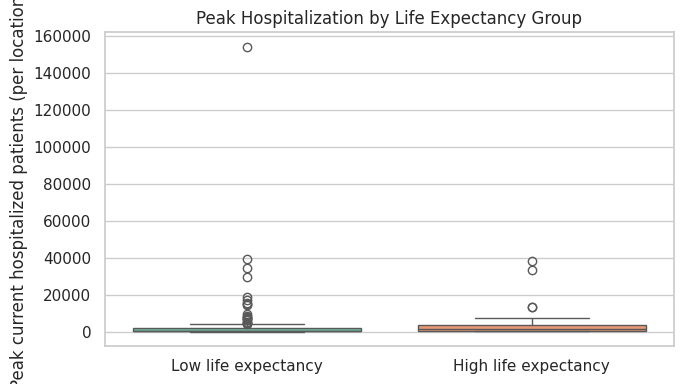

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(
    data=burden_df.dropna(subset=["life_group"]),
    x="life_group",
    y="peak_current_hospitalized",
    palette="Set2"
)
plt.title("Peak Hospitalization by Life Expectancy Group")
plt.xlabel("")
plt.ylabel("Peak current hospitalized patients (per location)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2429910029.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


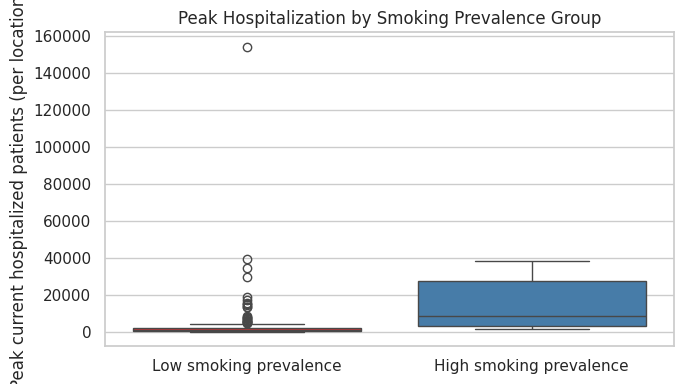

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(
    data=burden_df.dropna(subset=["smoke_group"]),
    x="smoke_group",
    y="peak_current_hospitalized",
    palette="Set1"
)
plt.title("Peak Hospitalization by Smoking Prevalence Group")
plt.xlabel("")
plt.ylabel("Peak current hospitalized patients (per location)")
plt.tight_layout()
plt.show()


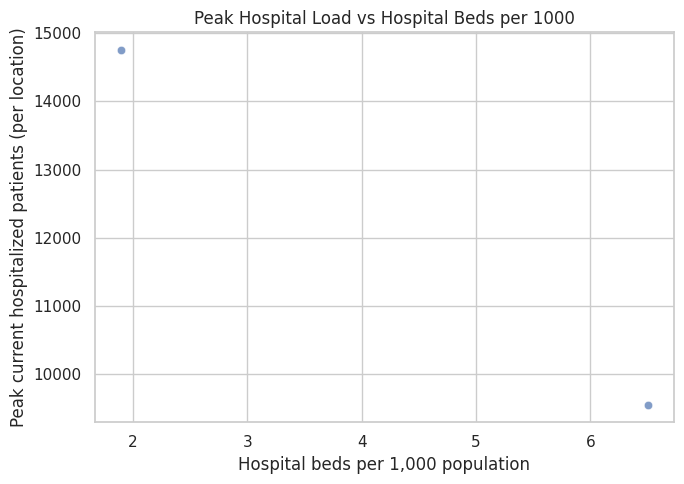

In [ ]:
# Peak current hospitalized per location (from merged or csv)
peak_by_loc = (
    df_merged
    .groupby("location_key")["current_hospitalized_patients"]
    .max()
    .reset_index(name="peak_current_hospitalized")
)

# Capacity metrics from json side (already in df_merged)
capacity_cols = ["location_key", "hospital_beds_per_1000"]
capacity = df_merged[capacity_cols].drop_duplicates("location_key")

scatter_df = peak_by_loc.merge(capacity, on="location_key", how="left")

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=scatter_df,
    x="hospital_beds_per_1000",
    y="peak_current_hospitalized",
    alpha=0.7
)
plt.title("Peak Hospital Load vs Hospital Beds per 1000")
plt.xlabel("Hospital beds per 1,000 population")
plt.ylabel("Peak current hospitalized patients (per location)")
plt.tight_layout()
plt.show()


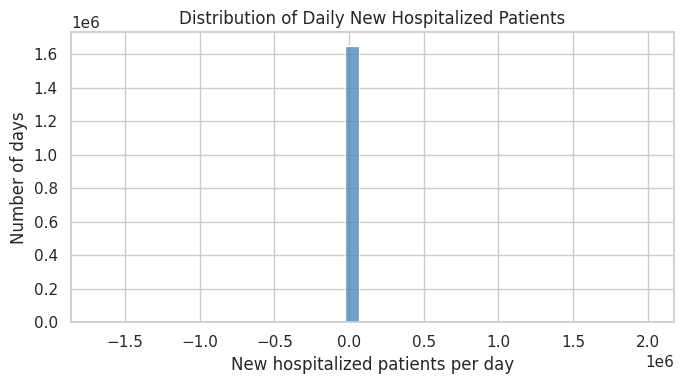

Summary: Most days have relatively low numbers of new hospitalizations, with a long tail of high‑burden days.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1A. Histogram of daily new hospitalized patients
plt.figure(figsize=(7,4))
sns.histplot(
    df_dedup["new_hospitalized_patients"].dropna(),
    bins=40,
    color="steelblue"
)
plt.title("Distribution of Daily New Hospitalized Patients")
plt.xlabel("New hospitalized patients per day")
plt.ylabel("Number of days")
plt.tight_layout()
plt.show()

print(
    "Summary: Most days have relatively low numbers of new hospitalizations, "
    "with a long tail of high‑burden days."
)


/tmp/ipython-input-1697199297.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


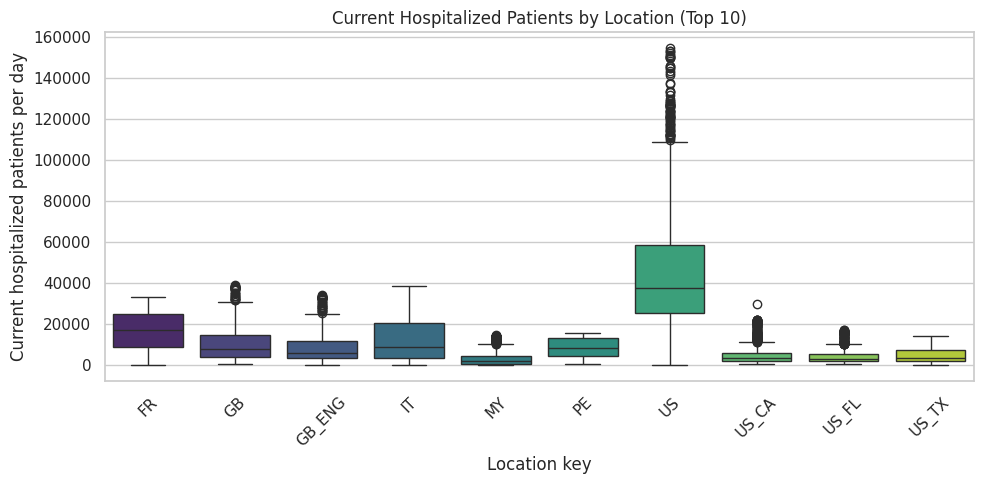

Summary: This boxplot highlights variation in daily hospital load across the 10 busiest locations.


In [ ]:
# 1B. Boxplot of current hospitalized by location (top 10 locations by volume)

top_locations = (
    df_dedup.groupby("location_key")["current_hospitalized_patients"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

plt.figure(figsize=(10,5))
sns.boxplot(
    data=df_dedup[df_dedup["location_key"].isin(top_locations)],
    x="location_key",
    y="current_hospitalized_patients",
    palette="viridis"
)
plt.title("Current Hospitalized Patients by Location (Top 10)")
plt.xlabel("Location key")
plt.ylabel("Current hospitalized patients per day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(
    "Summary: This boxplot highlights variation in daily hospital load across "
    "the 10 busiest locations."
)


/tmp/ipython-input-3057085514.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


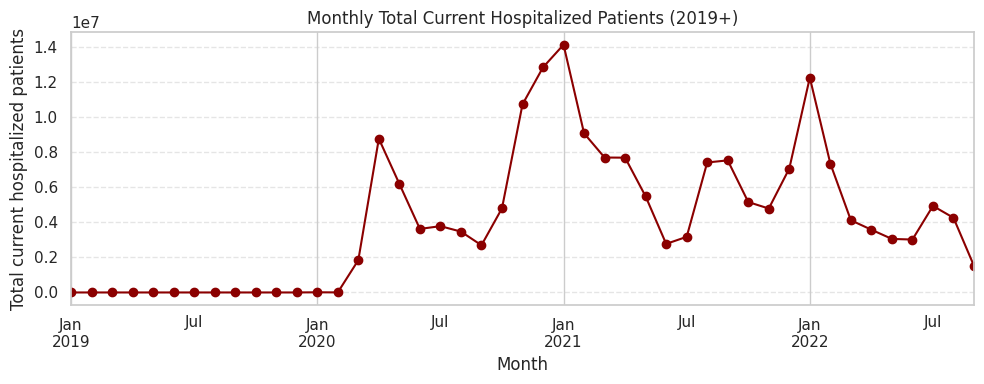

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Ensure date is parsed once, then reuse
df_ts = df_csv.copy()
df_ts["date"] = pd.to_datetime(df_ts["date"], errors="coerce")
df_ts = df_ts.dropna(subset=["date"])

monthly_ts = (
    df_ts
    .set_index("date")["current_hospitalized_patients"]
    .resample("M")
    .sum()
)


plt.figure(figsize=(10,4))
zoom_ts.plot(marker="o", linewidth=1.5, color="darkred")
plt.title("Monthly Total Current Hospitalized Patients (2019+)")
plt.xlabel("Month")
plt.ylabel("Total current hospitalized patients")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



/tmp/ipython-input-553078769.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


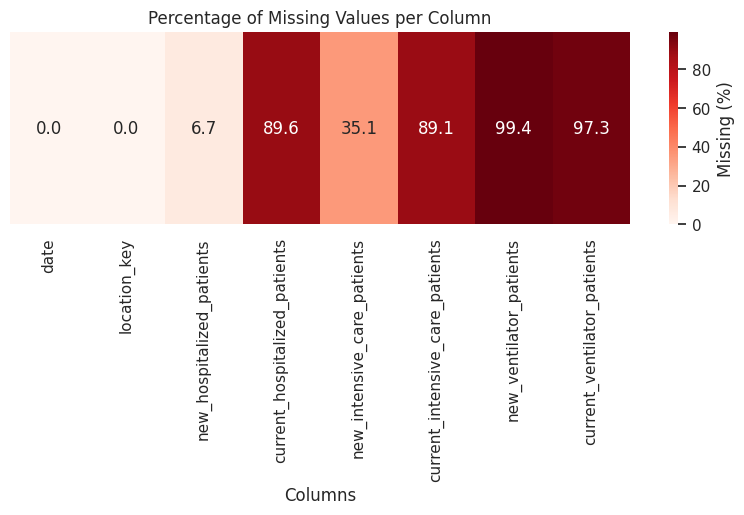

Missing percentage by column:
date                                0.0
location_key                        0.0
new_hospitalized_patients           6.7
current_hospitalized_patients      89.6
new_intensive_care_patients        35.1
current_intensive_care_patients    89.1
new_ventilator_patients            99.4
current_ventilator_patients        97.3
dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose hospitalization columns of interest
cols = [
    "date",
    "location_key",
    "new_hospitalized_patients",
    "current_hospitalized_patients",
    "new_intensive_care_patients",
    "current_intensive_care_patients",
    "new_ventilator_patients",
    "current_ventilator_patients",
]
cols = [c for c in cols if c in df_dedup.columns]

# 1 row × N columns matrix with % missing
missing_pct = df_dedup[cols].isnull().mean() * 100
missing_matrix = missing_pct.to_frame().T  # shape (1, n_cols)

plt.figure(figsize=(10, 2.5))
sns.heatmap(
    missing_matrix,
    annot=True,
    fmt=".1f",
    cmap="Reds",
    cbar_kws={"label": "Missing (%)"}
)
plt.yticks([])  # hide the single row label
plt.title("Percentage of Missing Values per Column")
plt.xlabel("Columns")
plt.tight_layout()
plt.show()

print("Missing percentage by column:")
print(missing_pct.round(1))


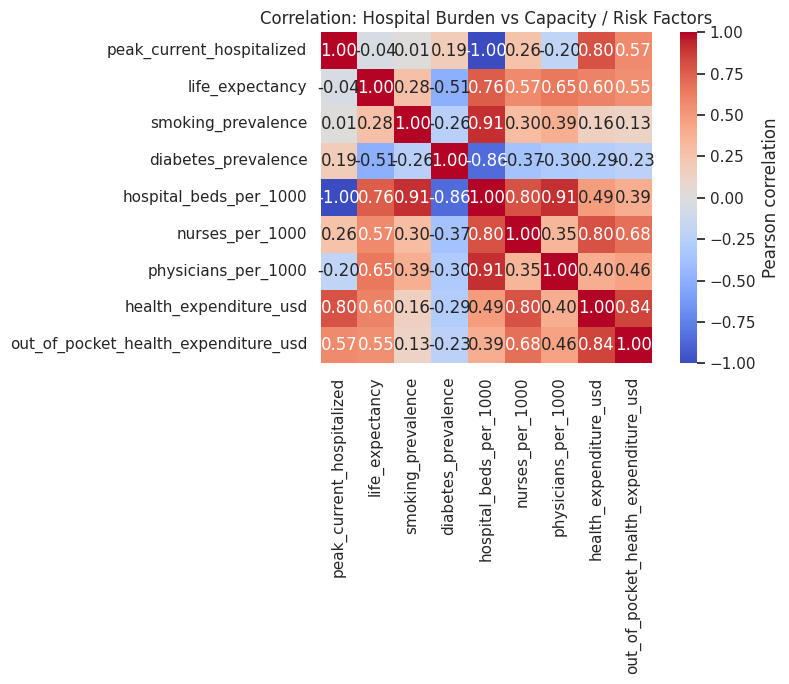

In [ ]:
# SECTION D: Correlation heatmap combining burden + capacity

# Re-create df_merged and df_dedup to ensure all columns from df_csv and df_json are present
# This addresses an issue where df_merged/df_dedup might have been overwritten
# by previous cells, losing the df_json columns needed for this analysis.
df_merged = pd.merge(
    df_csv,
    df_json,
    on="location_key",
    how="left"
)
df_dedup = df_merged.drop_duplicates(subset=["date", "location_key"])

peak_loc = (
    df_dedup
    .groupby("location_key")["current_hospitalized_patients"]
    .max()
    .reset_index(name="peak_current_hospitalized")
)

cap_cols = [
    "location_key",
    "life_expectancy",
    "smoking_prevalence",
    "diabetes_prevalence",
    "hospital_beds_per_1000",
    "nurses_per_1000",
    "physicians_per_1000",
    "health_expenditure_usd",
    "out_of_pocket_health_expenditure_usd",
]
cap_df = df_dedup[cap_cols].drop_duplicates("location_key")

combo = peak_loc.merge(cap_df, on="location_key", how="left")

num_cols = [c for c in combo.columns if combo[c].dtype != "O"]
corr = combo[num_cols].corr()

plt.figure(figsize=(9,7))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={"label": "Pearson correlation"}
)
plt.title("Correlation: Hospital Burden vs Capacity / Risk Factors")
plt.tight_layout()
plt.show()


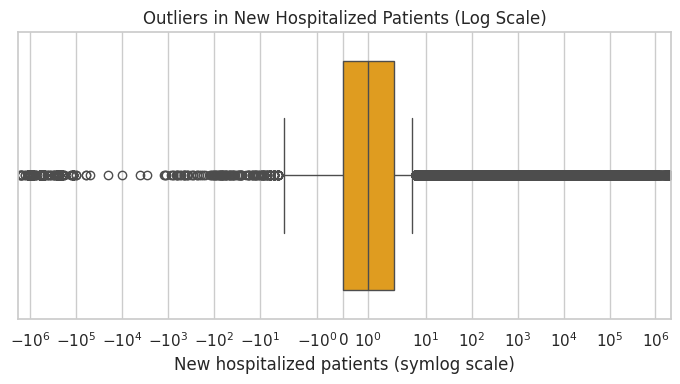

Summary: Using the 1.5×IQR rule, there are 259097 high‑burden days flagged as potential outliers in new hospitalizations.


In [ ]:
# 2B. Outlier detection with boxplot (log scale) for new hospitalized patients

plt.figure(figsize=(7,4))
sns.boxplot(
    x=df_dedup["new_hospitalized_patients"],
    color="orange"
)
plt.xscale("symlog")  # handles a wide range while keeping 0 visible
plt.title("Outliers in New Hospitalized Patients (Log Scale)")
plt.xlabel("New hospitalized patients (symlog scale)")
plt.tight_layout()
plt.show()

q1 = df_dedup["new_hospitalized_patients"].quantile(0.25)
q3 = df_dedup["new_hospitalized_patients"].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
outlier_count = (df_dedup["new_hospitalized_patients"] > upper).sum()

print(
    f"Summary: Using the 1.5×IQR rule, there are {outlier_count} high‑burden "
    "days flagged as potential outliers in new hospitalizations."
)


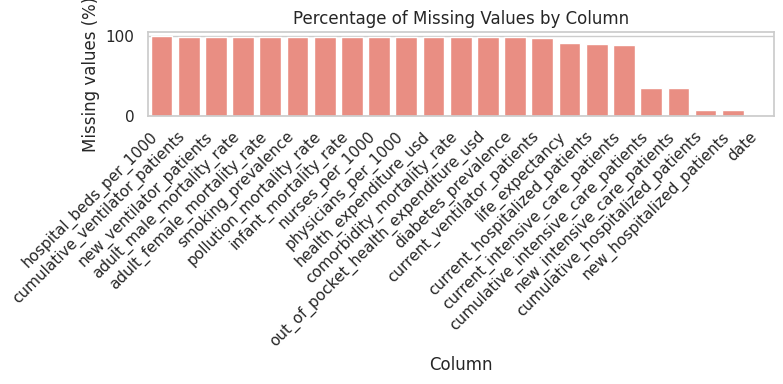

Summary: This bar chart highlights which fields need the most attention for data completion or imputation.


In [ ]:
# 2C. Bar chart of missingness percentage by column

missing_pct = df_dedup.isnull().mean().sort_values(ascending=False) * 100
missing_pct = missing_pct[missing_pct > 0]  # only columns with missing

plt.figure(figsize=(8,4))
sns.barplot(
    x=missing_pct.index,
    y=missing_pct.values,
    color="salmon"
)
plt.title("Percentage of Missing Values by Column")
plt.ylabel("Missing values (%)")
plt.xlabel("Column")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(
    "Summary: This bar chart highlights which fields need the most attention "
    "for data completion or imputation."
)
